In [101]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from metrics import ClusteringMetrics
import time
from PCA import PCA
from gmm import GMM


In [102]:
np.random.seed(42)

In [103]:
data,target = load_breast_cancer(return_X_y=True,as_frame=False)
data = StandardScaler().fit_transform(data)
metrics = ClusteringMetrics()

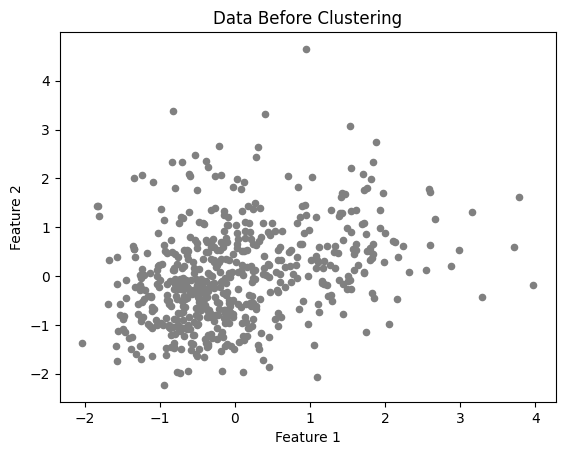

In [104]:
plt.scatter(data[:, 0], data[:, 1], s=20, c='gray')
plt.title("Data Before Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [105]:
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [106]:

def initialize(data, k):
    centroids = []
    centroids.append(data[np.random.randint(data.shape[0])]) # First centroid is random 

    for _ in range(k - 1):
        distances = []
        for point in data:
            min_dist = min([distance(point, c) for c in centroids]) # Distance to closest centroid
            distances.append(min_dist)
        
        next_centroid = data[np.argmax(distances)] # farthest point is the next centroid
        centroids.append(next_centroid)
    
    return np.array(centroids)


In [107]:
def random_initialization(data, k):
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    return centroids

In [108]:
def assign_to_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = []
        for c in centroids:
            distances.append(distance(point, c))

        cluster = np.argmin(distances) # index of closest centroid
        clusters.append(cluster) # assign point to closest centroid
    return np.array(clusters) # array of cluster for every point

In [109]:
def update_centroids(data, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = data[clusters == i] # get points assigned to cluster i
        new_centroid = np.mean(cluster_points, axis=0) # mean of points in cluster i
        new_centroids.append(new_centroid)
    return np.array(new_centroids)

In [110]:
def calculate_inertia(data, centroids, clusters):
    inertia = 0
    for i, point in enumerate(data):
        centroid = centroids[clusters[i]] # centroid of assigned cluster
        inertia += np.linalg.norm(point - centroid)**2 # sum of squared norm of point to centroid
    return inertia

In [111]:
def kmeans(data, centroids, tolerance, max_iterations):
    inertia_history = []
    startTime = time.time()
    while(max_iterations > 0):
        clusters = assign_to_clusters(data, centroids)
        inertia = calculate_inertia(data, centroids, clusters)
        new_centroids = update_centroids(data, clusters, len(centroids))
        inertia_history.append(inertia) 
        diff=0
        for i in range(len(centroids)):
            diff += distance(centroids[i], new_centroids[i])
        centroids = new_centroids

        if diff < tolerance:
            break
        max_iterations -= 1
    endTime = time.time()
    convergenceTime = endTime - startTime
    return centroids, clusters, inertia_history, convergenceTime

In [112]:
def elbow_method(data, max_k, tolerance, max_iterations, initializationType=initialize):
    inertia_values = []
    for k in range(1, max_k + 1):

        best_inertia = float('inf')
        times=[]
        for _ in range(10):  # 10 runs for each k to fix increasing inertia issue
            centroids = initializationType(data, k)
            _, _, inertia_history, t = kmeans(data, centroids, tolerance, max_iterations)
            times.append(t)
            if inertia_history[-1] < best_inertia:
                best_inertia = inertia_history[-1]
        inertia_values.append(best_inertia)
        print(f'k={k}, Best Inertia={best_inertia}, Average Convergence Time={np.mean(times):.4f} seconds')
    if len(inertia_values) > 2: # at least 3 points to find elbow
        x = np.arange(1, max_k + 1) 
        y = np.array(inertia_values)
        
        # normalize
        x_norm = (x - x[0]) / (x[-1] - x[0])
        y_norm = (y - y[0]) / (y[-1] - y[0])
        
        # distance from each point to the line connecting first and last
        distances = []
        for i in range(len(x_norm)):
            # distance from point to line
            dist = abs(y_norm[i] - x_norm[i])
            distances.append(dist)
        
        elbow_k = np.argmax(distances) + 1
    else:
        elbow_k = 2
    plt.scatter([elbow_k], [inertia_values[elbow_k-1]], 
                color='red', s=300, marker='X', zorder=5, 
                label=f'Optimal k = {elbow_k}', edgecolors='black', linewidths=2)
    print("Convergence iterations (speed): ", len(inertia_history))
    plt.plot(range(1, max_k + 1), inertia_values, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.show()

k=1, Best Inertia=17069.999999999993, Average Convergence Time=0.0405 seconds
k=2, Best Inertia=11595.461473962347, Average Convergence Time=0.2980 seconds
k=3, Best Inertia=10061.797818243695, Average Convergence Time=0.4178 seconds
k=4, Best Inertia=9574.371583740492, Average Convergence Time=0.7884 seconds
k=5, Best Inertia=8898.604283828121, Average Convergence Time=0.5790 seconds
k=6, Best Inertia=8477.230050907636, Average Convergence Time=0.8030 seconds
k=7, Best Inertia=7849.212159929443, Average Convergence Time=0.9400 seconds
k=8, Best Inertia=7357.98283295799, Average Convergence Time=1.4609 seconds
k=9, Best Inertia=6979.745628456275, Average Convergence Time=1.2933 seconds
k=10, Best Inertia=6914.958836878349, Average Convergence Time=1.3550 seconds
Convergence iterations (speed):  24


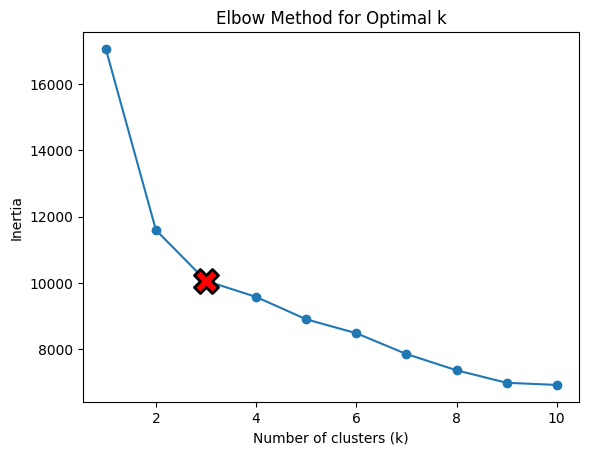

In [113]:
elbow_method(data, 10, tolerance=1e-4, max_iterations=100)

In [114]:
def calculate_silhouette_score(data, clusters, centroids):
    silhouette_scores = []
    for i, my_point in enumerate(data):
        cluster = clusters[i]
        same_cluster_points = data[clusters == cluster]
        if len(same_cluster_points) > 1:
            distances=[]
            for point in same_cluster_points:
                if not np.array_equal(my_point, point):
                    dist = distance(my_point, point)
                    distances.append(dist)
            a_i = np.mean(distances) # average distance to other points in the same cluster

        else:
            a_i = 0
        
        b_i = float('inf')
        for j, _ in enumerate(centroids):
            if j != cluster:
                other_cluster_points = data[clusters == j] # points in other clusters
                distances = []
                for point in other_cluster_points:
                    dist = distance(my_point, point)
                    distances.append(dist)
                avg_dist = np.mean(distances) # average distance to points in other cluster
                if avg_dist < b_i:
                    b_i = avg_dist 
        
        # calculate silhouette score for point i
        if max(a_i, b_i) > 0:
            s_i = (b_i - a_i) / max(a_i, b_i)
        else:
            s_i = 0
        silhouette_scores.append(s_i)
    
    return np.mean(silhouette_scores)

In [115]:
def silhouette_analysis(data, max_k, tolerance, max_iterations, inializationType=initialize):
    sil_scores = []
    for k in range(2, max_k + 1):
        centroids = inializationType(data, k)
        centroids, clusters, inertia_history, convergenceTime = kmeans(data, centroids, tolerance, max_iterations)
        sil_score = calculate_silhouette_score(data, clusters, centroids)
        sil_scores.append(sil_score)
    plt.plot(range(2, max_k + 1), sil_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis for Optimal k')
    plt.show()

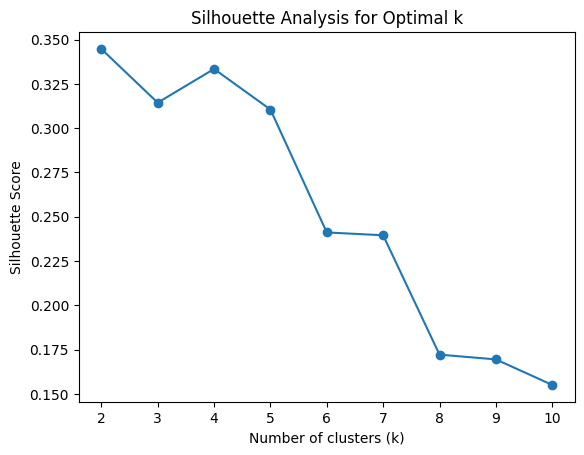

In [116]:
silhouette_analysis(data, 10, tolerance=1e-4, max_iterations=100)

In [128]:
def gap_statistics(data, max_k, b=10, tolerance=1e-4, max_iterations=100, initializationType=initialize):
    import numpy as np

    def generate_reference_data(x):
        return np.random.uniform(low=x.min(axis=0), high=x.max(axis=0), size=x.shape) # generate random reference data

    gap_values = []
    for k in range(1, max_k + 1):
        centroids = initializationType(data, k)
        centroids, clusters, _, _ = kmeans(data, centroids, tolerance, max_iterations)
        orig_inertia = calculate_inertia(data, centroids, clusters)
        ref_inertias = []
        for _ in range(b): # b reference datasets
            ref_data = generate_reference_data(data)
            ref_centroids = initializationType(ref_data, k)
            ref_centroids, ref_clusters, _, _ = kmeans(ref_data, ref_centroids, tolerance, max_iterations)
            ref_inertia = calculate_inertia(ref_data, ref_centroids, ref_clusters)
            ref_inertias.append(ref_inertia)

        gap_value = np.log(np.mean(ref_inertias)) - np.log(orig_inertia) # compare log inertias (log for scaling)
        gap_values.append(gap_value)
    plt.plot(range(1, max_k + 1), gap_values, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic Method for Optimal k')
    plt.show()

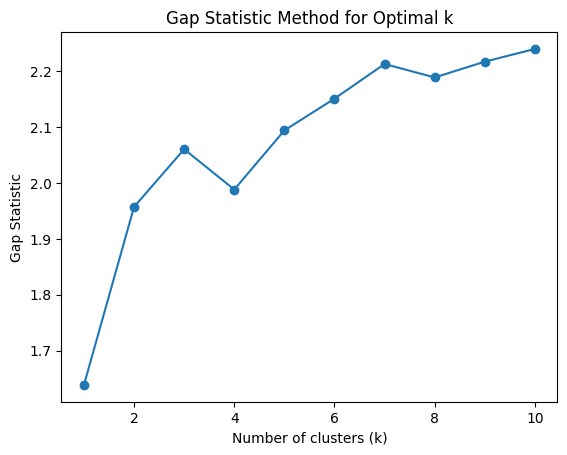

In [129]:
gap_statistics(data, 10, b=10, tolerance=1e-4, max_iterations=100)

k=1, Best Inertia=17069.999999999993, Average Convergence Time=0.0364 seconds
k=2, Best Inertia=11595.461473962347, Average Convergence Time=0.1877 seconds
k=3, Best Inertia=10061.797818243695, Average Convergence Time=0.4762 seconds
k=4, Best Inertia=9331.967113601004, Average Convergence Time=0.5717 seconds
k=5, Best Inertia=8558.18693522358, Average Convergence Time=1.0297 seconds
k=6, Best Inertia=7976.42771494189, Average Convergence Time=1.1245 seconds
k=7, Best Inertia=7539.990912413907, Average Convergence Time=1.2152 seconds
k=8, Best Inertia=7212.646925013721, Average Convergence Time=1.5169 seconds
k=9, Best Inertia=6858.484138981563, Average Convergence Time=1.4566 seconds
k=10, Best Inertia=6699.901276281237, Average Convergence Time=1.8383 seconds
Convergence iterations (speed):  32


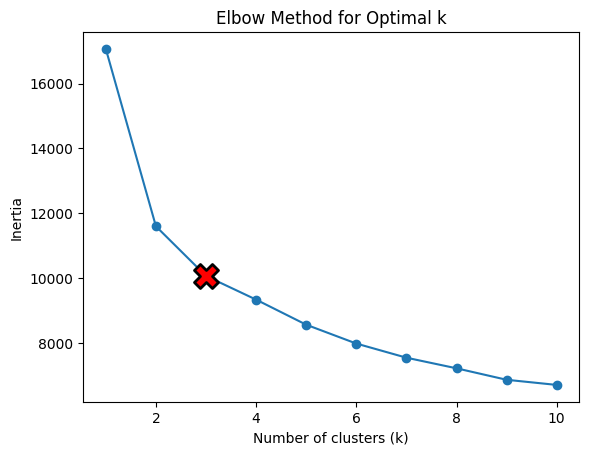

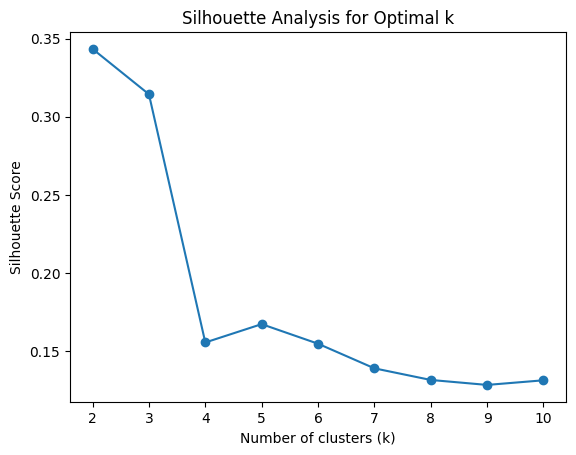

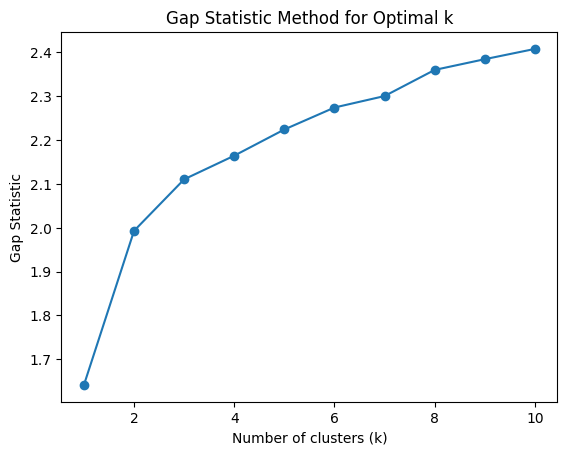

In [119]:
elbow_method(data, 10, tolerance=1e-4, max_iterations=100, initializationType=random_initialization)
silhouette_analysis(data, 10, tolerance=1e-4, max_iterations=100, inializationType=random_initialization)
gap_statistics(data, 10, b=10, tolerance=1e-4, max_iterations=100, initializationType=random_initialization)

Text(0.5, 1.0, 'K-Means Clustering Results after PCA')

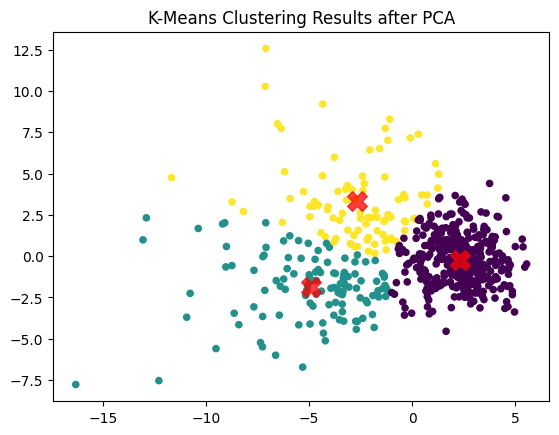

In [120]:
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
data_normalized = (data - mean) / std
pca_model = PCA(n_components=2)
pca_data = pca_model.fit(data_normalized).transform(data_normalized)
pca_centroids = initialize(pca_data, k=3)
pca_centroids, pca_clusters, pca_inertia_history, pca_convergenceTime = kmeans(pca_data, pca_centroids, tolerance=1e-4, max_iterations=100)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_clusters, s=20, cmap='viridis')
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')
plt.title("K-Means Clustering Results after PCA")

Dimension: 2, Silhouette Score: 0.4910, Convergence Time: 0.3459 seconds
Dimension: 5, Silhouette Score: 0.3616, Convergence Time: 0.3556 seconds
Dimension: 10, Silhouette Score: 0.3277, Convergence Time: 0.4008 seconds
Dimension: 15, Silhouette Score: 0.3184, Convergence Time: 0.3922 seconds
Dimension: 20, Silhouette Score: 0.3162, Convergence Time: 0.4196 seconds


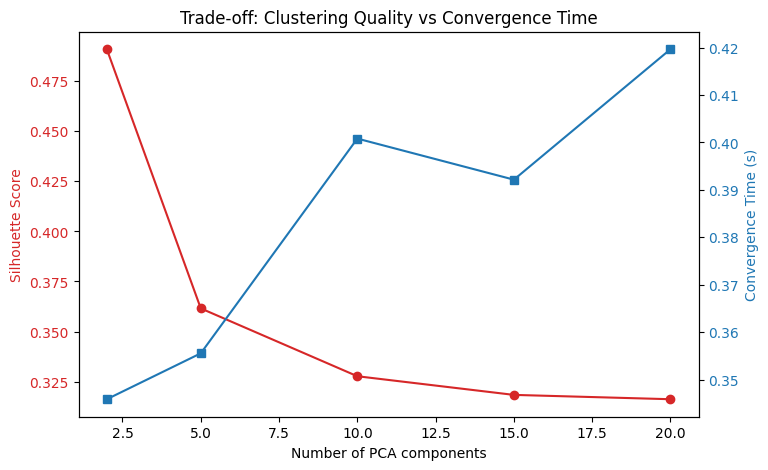

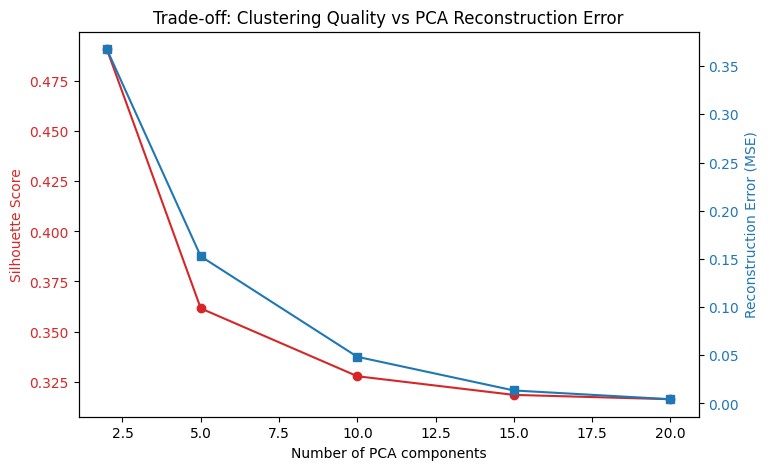

In [124]:
dimensions = [2, 5, 10, 15, 20]
convergence_times = []
sil_scores = []
reconstruction_errors = []
for dim in dimensions:
    pca_model = PCA(n_components=dim)
    reduced_data = pca_model.fit(data_normalized).transform(data_normalized)  # normalized data
    centroids = initialize(reduced_data, k=3)
    centroids, clusters, inertia_history, convergenceTime = kmeans(
        reduced_data, centroids, tolerance=1e-4, max_iterations=100
    )
    
    sil_score = calculate_silhouette_score(reduced_data, clusters, centroids)
    rec_error = pca_model.calculate_reconstruction_error(data_normalized)
    reconstruction_errors.append(rec_error)

    
    sil_scores.append(sil_score)
    convergence_times.append(convergenceTime)
    
    print(f'Dimension: {dim}, Silhouette Score: {sil_score:.4f}, Convergence Time: {convergenceTime:.4f} seconds')

fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:red'
ax1.set_xlabel('Number of PCA components')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(dimensions, sil_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Convergence Time (s)', color=color)
ax2.plot(dimensions, convergence_times, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Trade-off: Clustering Quality vs Convergence Time")
plt.show()

fig, ax1 = plt.subplots(figsize=(8,5))

# Left Y-axis: Silhouette Score
color = 'tab:red'
ax1.set_xlabel('Number of PCA components')
ax1.set_ylabel('Silhouette Score', color=color)
ax1.plot(dimensions, sil_scores, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Right Y-axis: Reconstruction Error
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Reconstruction Error (MSE)', color=color)
ax2.plot(dimensions, reconstruction_errors, marker='s', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Trade-off: Clustering Quality vs PCA Reconstruction Error")
plt.show()


PCA Dim: 2, GMM Covariance Type: full, Silhouette Score: 0.4563
PCA Dim: 2, GMM Covariance Type: tied, Silhouette Score: 0.5074
PCA Dim: 2, GMM Covariance Type: diagonal, Silhouette Score: 0.4515
PCA Dim: 2, GMM Covariance Type: spherical, Silhouette Score: 0.2540
PCA Dim: 5, GMM Covariance Type: full, Silhouette Score: 0.2596
PCA Dim: 5, GMM Covariance Type: tied, Silhouette Score: 0.2254
PCA Dim: 5, GMM Covariance Type: diagonal, Silhouette Score: 0.3178
PCA Dim: 5, GMM Covariance Type: spherical, Silhouette Score: 0.1085
PCA Dim: 10, GMM Covariance Type: full, Silhouette Score: 0.1672
PCA Dim: 10, GMM Covariance Type: tied, Silhouette Score: 0.3380
PCA Dim: 10, GMM Covariance Type: diagonal, Silhouette Score: 0.2499
PCA Dim: 10, GMM Covariance Type: spherical, Silhouette Score: 0.2725
PCA Dim: 15, GMM Covariance Type: full, Silhouette Score: 0.1955
PCA Dim: 15, GMM Covariance Type: tied, Silhouette Score: 0.3438
PCA Dim: 15, GMM Covariance Type: diagonal, Silhouette Score: 0.1345
PC

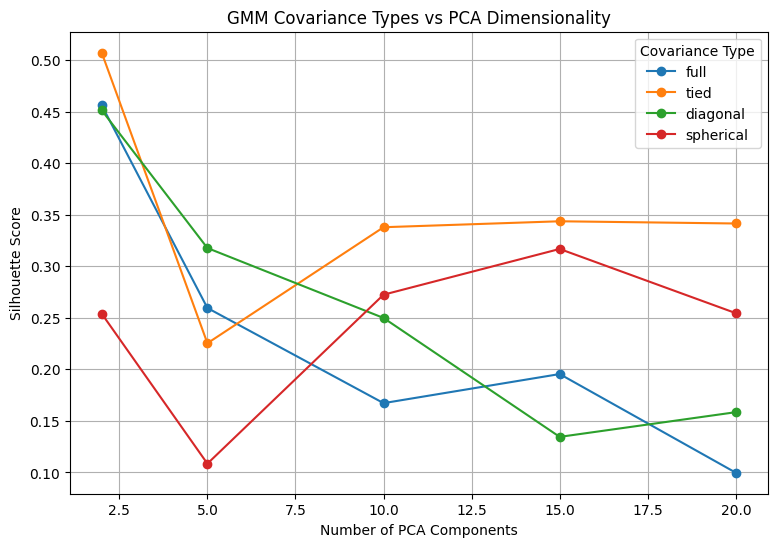

In [127]:
covariance_types = ['full', 'tied', 'diagonal', 'spherical']
silhouette_results = {cov: [] for cov in covariance_types}
for dim in dimensions:
    pca_model = PCA(n_components=dim)
    reduced_data = pca_model.fit(data_normalized).transform(data_normalized)  # normalized data

    for cov_type in covariance_types:
        gmm_model = GMM(n_components=3, covariance_type=cov_type, max_iter=100, regularized_covariance=1e-6)
        gmm_model.fit(reduced_data)
        clusters = gmm_model.predict(reduced_data)
        sil_score = calculate_silhouette_score(reduced_data, clusters, gmm_model.means)
        print(f'PCA Dim: {dim}, GMM Covariance Type: {cov_type}, Silhouette Score: {sil_score:.4f}')
        silhouette_results[cov_type].append(sil_score)

plt.figure(figsize=(9,6))

for cov_type in covariance_types:
    plt.plot(
        dimensions,
        silhouette_results[cov_type],
        marker='o',
        label=cov_type
    )

plt.xlabel("Number of PCA Components")
plt.ylabel("Silhouette Score")
plt.title("GMM Covariance Types vs PCA Dimensionality")
plt.legend(title="Covariance Type")
plt.grid(True)
plt.show()
